In [ ]:
import kagglehub
import numpy as np
import pandas as pd             #Importing Necessary libraries
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv("data.csv")    #Reading the data into a pandas dataframe

In [ ]:
names=list(set(data['Company']))



Data={}
for name in names:                          #Creates a dictionary for the stocks from each company
    Data[name]=data[data['Company']==name]

print(Data['AAPL'].head())

scales={}
for key in Data.keys():                                                             #Removes unnecessary columns for each day, leaving only the
    Data[key]=Data[key].reset_index(drop=True)                                      #Close/Open/High/Low for each stock on a given day
    Data[key]=Data[key].loc[:,['Close/Last','Open','High','Low']]
    Data[key].columns=['Close','Open','High','Low']
    temp=[]
    for col in Data[key].columns:                                                   #Casts the dollar amount into a float
        Data[key][col]=Data[key][col].apply(lambda x: x.strip('$')).astype(float)
        temp.append(Data[key][col][0])
        Data[key][col]=Data[key][col]/Data[key][col][0]                             #Scales each stocks data by the first entry in each column
    scales[key]=temp









Apple={}                                 #Separates the Apple stock data from all the other stocks
Apple['AAPL']=Data['AAPL'].copy()
Data.pop('AAPL')
Data['AMD'].head()




  Company        Date Close/Last    Volume     Open       High      Low
0    AAPL  07/17/2023    $193.99  50520160  $191.90    $194.32  $191.81
1    AAPL  07/14/2023    $190.69  41616240  $190.23  $191.1799  $189.63
2    AAPL  07/13/2023    $190.54  41342340  $190.50    $191.19  $189.78
3    AAPL  07-12-2023    $189.77  60750250  $189.68    $191.70  $188.47
4    AAPL  07-11-2023    $188.08  46638120  $189.16    $189.30  $186.60


,Close,Open,High,Low
0,1.000000,1.000000,1.000000,1.000000
1,0.979885,1.001897,1.027601,1.022354
2,0.979716,0.998361,0.977449,1.007496
3,0.968391,0.973609,0.971053,0.996275
4,0.940838,0.963001,0.953131,0.971347


In [ ]:
def train(ddata,stock):
    ddata=ddata[stock][['Close','Open','High','Low']].copy()

    #ddata=ddata.iloc[:int(1*ddata.shape[0]),:]

    ddata.columns=['Close','Open','High','Low']

    A=[]
    y=[]
    ddata=ddata.T
    m=ddata.shape[1]-10-1
    for i in range(m):                                  #Groups data into 10 day chunks with a matching next-day value for each stock metric
        A.append(ddata.iloc[:,i:i+10].values)
        #print(i)
        y.append(ddata.iloc[:,i+11].values)

    B=pd.concat([pd.DataFrame(A[i]) for i in range(len(A))])        #Creates the dataframe representing the regression features
    B.reset_index(drop=True,inplace=True)

    Y=pd.concat([pd.DataFrame(y[i]) for i in range(len(y))],axis=0) #Creates the vector that needs to be predicted
    Y.reset_index(drop=True,inplace=True)
    B=np.array(B)
    Y=np.array(Y)
    U,S,Vt=np.linalg.svd(B,full_matrices=False)                     #Decoposes the regression feature matrix using SVD
    V=Vt.T
    a_hat=V@np.diag(1/S)@U.T@Y                                      #Produces the vector that represents the linear model
    return B,Y,a_hat                                                #Returns the feature library matrix, the vector we wish to represent, the projection in the new basis

def RMSE(A):
    return np.sqrt(np.linalg.norm(A,ord=2)**2/len(A))           #Returns the RMSE of the difference-vector, A

class money_test():
    def __init__(self,data,close,a_hat):                        #Python class that runs the simulation to test with fake money, using a given linear model
        self.money=1000
        self.close=close
        self.data=data
        self.a_hat=a_hat

        self.mon_time=[]
        i=0
        for day in self.data:
            tomm=self.model(day)                                #makes a prediction of the next day using the previous 10 days day
            #print(day[0,-1],tomm[0],close[i])
            self.decide(day[0,-1],tomm[0],self.close[i])        #Makes a decision to buy or sell
            self.mon_time.append(self.money)                    #Records the amount of money after the decision
            i+=1

        print(self.money)

    def model(self,dat):                                        #Function to predict using the model
        a_hat=np.array(self.a_hat)
        return dat@a_hat

    def decide(self,today,tomm,close):                          #Function that modulates the money in hand based on if it predicts a raise in price, then regardless
        if tomm>today:                                          #of the accuracy of the prediction, updates the current money
            self.money*=close/today
        else:
            self.money*=1

In [ ]:
As=[]
Ys=[]

for key in Data.keys():                     #Creates the training data using the train() function to create matrix-vector pairs for each stock
    B,Y,a_hat=train(Data,key)               #and then concatenates them together in the training matrix and vector
    As.append(B)
    Ys.append(Y)

All=pd.concat([pd.DataFrame(As[i]) for i in range(len(As))])
All.reset_index(drop=True,inplace=True)

Yall=pd.concat([pd.DataFrame(Ys[i]) for i in range(len(Ys))],axis=0)
Yall.reset_index(drop=True,inplace=True)

Aap,Yap,Aa_hat=train(Apple,'AAPL')          #Creates the testing data from the Apple stock data








In [ ]:
#print(All.iloc[:4,:])
print(As[0].shape)
print(All.shape,Aap.shape)

(10020, 10)
(90180, 10) (10020, 10)


In [ ]:
U,S,Vt=np.linalg.svd(All,full_matrices=False)           #Decompose the training matrix using SVD
V=Vt.T
x=V@np.diag(1/S)@U.T@Yall                               #Calculates the coefficients for the linear model using the pseudo-inverse
print(x)

          0
0 -0.013606
1 -0.002513
2  0.008500
3  0.000345
4  0.028986
5 -0.014561
6 -0.002027
7  0.020070
8 -0.027361
9  1.000811


0.020671215118480274 4.010009020833989


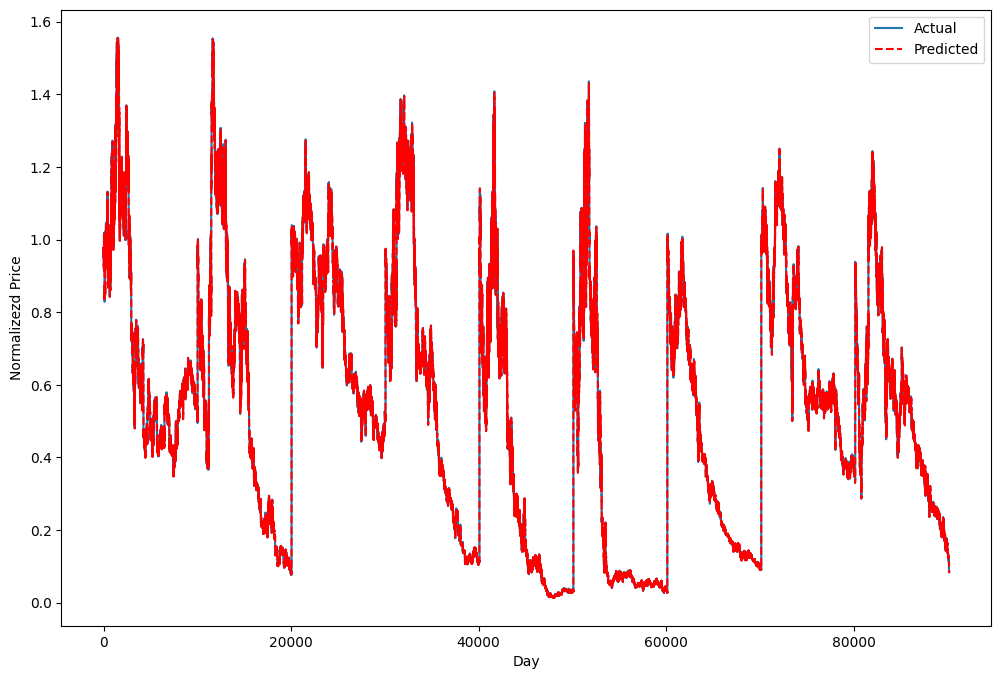

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Yall,label='Actual')
plt.plot(All@x,'r--',label='Predicted')
plt.xlabel('Day')
plt.ylabel('Normalizezd Price')
plt.legend()
plt.savefig('Training Data Fit.png')        #Produces a plot of the training data in blue and the prediction of that data using the linear model
r=RMSE(Yall-All@x)                          #Calculates the RMSE of the prediction
print(r,scales['AAPL'][0]*r)

0.011610516160661237 2.2523240300066734


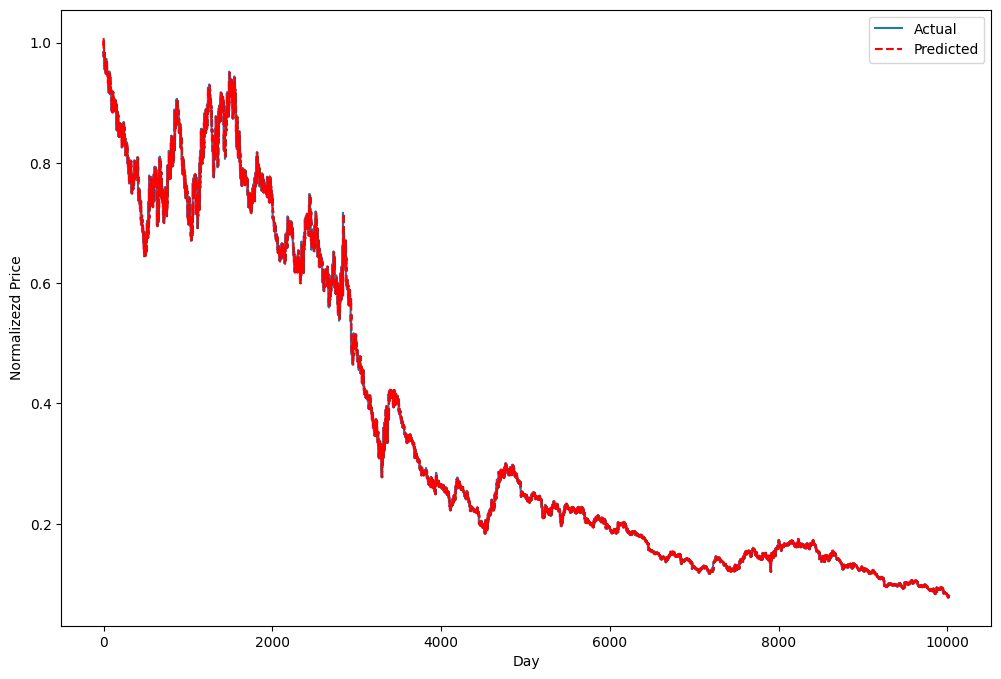

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Yap,label='Actual')
plt.plot(Aap@x,'r--',label='Predicted')
plt.xlabel('Day')
plt.ylabel('Normalizezd Price')
plt.legend()
plt.savefig('Testing Data Fit.png')             #Creates the same plot as before with the real test data in blue and the best-fit linear model in red
r=RMSE(Yap-Aap@x)                               #Calculates the RMSE for this prediction
print(r,scales['AAPL'][0]*r)

In [ ]:
test=Apple['AAPL']
m=test.shape[0]-11
test=test.T
Test=[]
for i in range(m):
    Test.append(test.iloc[:,i:i+10].values)
Final=np.array(Test)

1980.874901031144


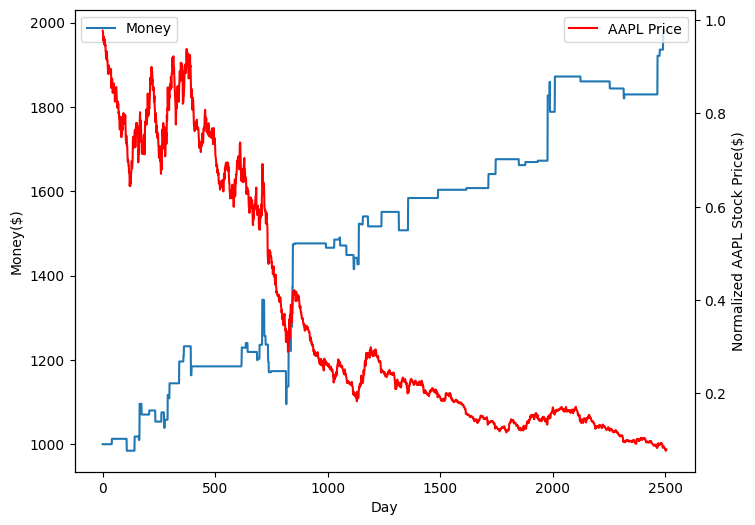

In [ ]:
y_test=np.array(Apple['AAPL'].iloc[11:,0])
tt=money_test(Final,y_test,x)                   #Creates the Python object that runs through the Apple data with fake money and returns the amount of money it has at the end

fig,ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot(tt.mon_time,label='Money')              #Plots the money the model has at each point in time
ax.set_xlabel('Day')
ax.set_ylabel('Money($)')
ax2=ax.twinx()
ax2.set_ylabel('Normalized AAPL Stock Price($)')
ax2.plot(y_test,'r',label='AAPL Price')         #Plots the next days close value for each day
ax.legend()
ax2.legend()
plt.savefig('Profit Linear.png')